In [160]:
import torch
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt



In [161]:
def generate_data(n_components=5, n_samples=100):
    # Generate means
    means = torch.rand(n_components, 2)
    # Generate variances
    variances = 0.03 * torch.ones((n_components,))
    # Generate X
    X = []
    Z = []
    for z in xrange(n_components):
        x = means[z] + variances[z] * torch.randn(n_samples, 2)
        X.append(x)
        Z.append(z*torch.ones(n_samples).long())
    X = torch.cat(X, 0)
    Z = torch.cat(Z, 0)
    return X, Z

def plot_samples(X, Z=None):
    plt.axis('equal')
    if Z is not None:
        z_max = Z.max()
        for z in xrange(z_max+1):
            X_z = X[Z==z]
            plt.scatter(X_z.numpy()[:,0], X_z.numpy()[:,1], label=z)
        plt.legend()
    else:
        plt.scatter(X.numpy()[:,0], X.numpy()[:,1])

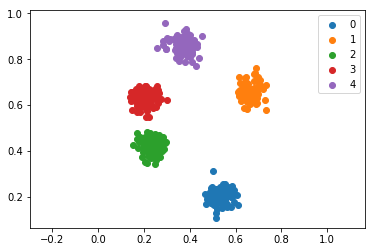

In [185]:
torch.manual_seed(7)
X, Z = generate_data()

plot_samples(X, Z)

# K-means

In [186]:
def get_pairwise_distances(m, n):
    assert m.size()[1] == n.size()[1]
    assert len(m.size()) == 2 and len(n.size()) == 2
    distance_matrix = ((m[:, :, None] - n.t()[None, :, :])**2).sum(1)
    return distance_matrix

# Example
m = torch.tensor([
    [1, 2],
    [3, 4],
    [5, 6]])

n = torch.tensor([
    [1, 2],
    [3, 4]])

get_pairwise_distances(m, n)

tensor([[  0,   8],
        [  8,   0],
        [ 32,   8]])

In [353]:
# Initialize
n_components = 5
#centroids = torch.rand(n_components, 2)
# initialize to 5 first points
centroids = X[:5].clone()
iterations = 35
for iteration in xrange(iterations):
    # Expectation
    distances = get_pairwise_distances(X, centroids)
    __, assignments = torch.min(distances, 1)
    # Minimization
    for i in xrange(n_components):
        centroids[i] = X[assignments == i].mean(0)

Text(0.5,1,'K-Means Cost 0.00617')

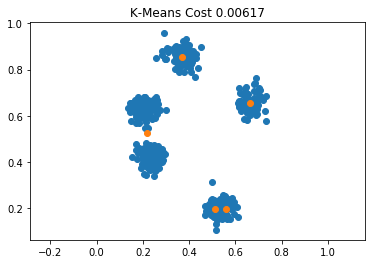

In [354]:
# Plot centroids
plt.figure()
plot_samples(X)
plot_samples(centroids)

# Plot loss
__, assignments = torch.min(distances, 1)
cost = ((X-centroids[assignments])**2).sum() / len(X)
plt.title('K-Means Cost {:.5f}'.format(cost))

# Wasserstein Clustering

In [543]:
def compute_sinkhorn(m, r=None, c=None, regularization=100., iterations=40):
    '''
    pairwise_distances: (batch, batch')
    r: (batch, dims) distribution (histogram)
    c: (batch', dims) distribution (histogram)
    '''
    # If no distributions are given, consider two uniform histograms
    if r is None:
        r = torch.ones(m.size()[0]) / m.size()[0]
    if c is None:
        c = torch.ones(m.size()[1]) / m.size()[1]
    
    # Initialize dual variable v (u is implicitly defined in the loop)
    v = torch.ones(m.size()[1])
    
    # Exponentiate the pairwise distance matrix
    K = torch.exp(-regularization * m)
    
    # Main loop
    for i in xrange(iterations):
        # Kdiag(v)_ij = sum_k K_ik diag(v)_kj = K_ij v_j
        # Pij = u_i K_ij v_j
        # sum_j Pij = u_i sum_j K_ij v_j = u_i (Kv)_i = r_i
        # -> u_i = r_i / (Kv)_i
        # K * v[None, :]
        
        # Match r marginals
        u = r / torch.matmul(K, v)

        # Match c marginals
        v = c / torch.matmul(u, K)
  
        #print 'P', P
        #print '~r', P.sum(1)
        #print '~c', P.sum(0)
        #print 'u', u
        #print 'v', v        
    # Compute optimal plan, cost, return everything
    P = u[:, None] * K * v[None, :]  # transport plan
    dst = (P * m).sum()
    
    return dst, P, u, v

def log_sum_exp(u, dim):
    # Reduce log sum exp along axis
    u_max, __ = u.max(dim=dim, keepdim=True)
    log_sum_exp_u = torch.log(torch.exp(u - u_max).sum(dim)) + u_max.sum(dim)
    return log_sum_exp_u
 
def naive_log_sum_exp(u, dim):
    return torch.log(torch.sum(torch.exp(u), dim))
    
def compute_sinkhorn_stable(m, r=None, c=None, regularization=100., iterations=40):
    # If no distributions are given, consider two uniform histograms
    if r is None:
        r = torch.ones(m.size()[0]) / m.size()[0]
    if c is None:
        c = torch.ones(m.size()[1]) / m.size()[1]
    log_r = torch.log(r)
    log_c = torch.log(c)
    
    # Initialize dual variable v (u is implicitly defined in the loop)
    log_v = torch.zeros(m.size()[1])  # ==torch.log(torch.ones(m.size()[1]))
    
    # Exponentiate the pairwise distance matrix
    log_K = -regularization * m
    
    # Main loop
    for i in xrange(iterations):

        # Match r marginals
        log_u = log_r - log_sum_exp(log_K + log_v[None, :], dim=1)
        
        # Match c marginals
        log_v = log_c - log_sum_exp(log_u[:, None] + log_K, dim=0)
        
    # Compute optimal plan, cost, return everything
    P = torch.exp(log_u[:, None] + log_K + log_v[None, :])  # transport plan
    dst = (P * m).sum()
    
    return dst, P, u, v

m = torch.tensor([[0,1],[1,0]]).float()
regularization = 0.01
dst, P, u, v = compute_sinkhorn(m, regularization=regularization)
print '\ndst', dst
print 'P', P
print 'u', u
print 'v', v

dst, P, u, v = compute_sinkhorn_stable(m, regularization=regularization)
print '\ndst', dst
print 'P', P
print 'u', u
print 'v', v


dst tensor(0.4975)
P tensor([[ 0.2512,  0.2488],
        [ 0.2488,  0.2512]])
u tensor([ 0.2512,  0.2512])
v tensor([ 1.,  1.])

dst tensor(0.4975)
P tensor([[ 0.2512,  0.2488],
        [ 0.2488,  0.2512]])
u tensor([ 0.2512,  0.2512])
v tensor([ 1.,  1.])



unstable dst nan
stable dst 0.548673272133
tensor([[ 0.4114,  0.5484],
        [ 0.4108,  0.5390],
        [ 0.4087,  0.5396],
        [ 0.3908,  0.5423],
        [ 0.4138,  0.5619]])
tensor([ 0.2000,  0.2000,  0.2000,  0.2000,  0.2000])

unstable dst nan
stable dst 0.0784144178033
tensor([[ 0.5510,  0.6509],
        [ 0.4980,  0.3247],
        [ 0.3663,  0.3694],
        [ 0.2007,  0.5650],
        [ 0.4136,  0.8539]])
tensor([ 0.2000,  0.2000,  0.2000,  0.2000,  0.2000])

unstable dst 0.0128771550953
stable dst 0.01287715137
tensor([[ 0.6579,  0.6702],
        [ 0.5399,  0.2001],
        [ 0.2387,  0.4202],
        [ 0.1922,  0.6178],
        [ 0.3769,  0.8488]])
tensor([ 0.2000,  0.2000,  0.2000,  0.2000,  0.2000])

unstable dst 0.00208151945844
stable dst 0.00208151922561
tensor([[ 0.6616,  0.6642],
        [ 0.5412,  0.2014],
        [ 0.2152,  0.4251],
        [ 0.2138,  0.6254],
        [ 0.3867,  0.8615]])
tensor([ 0.2000,  0.2000,  0.2000,  0.2000,  0.2000])

unstable dst 0.0

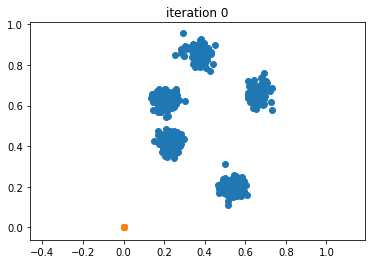

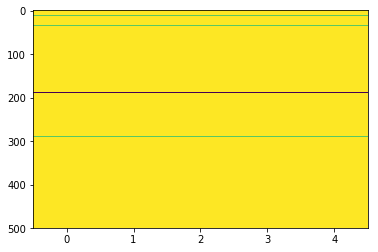

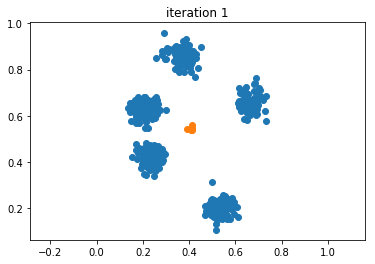

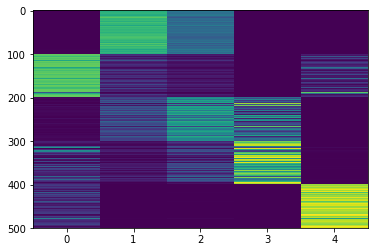

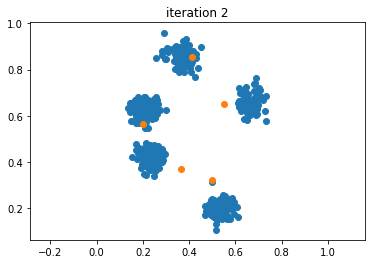

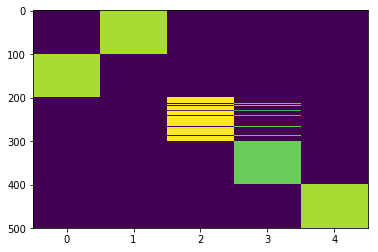

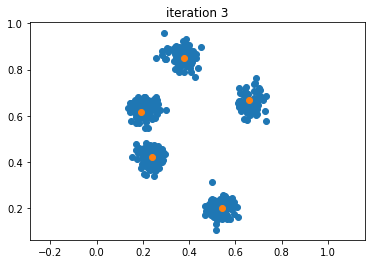

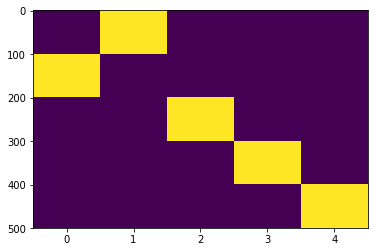

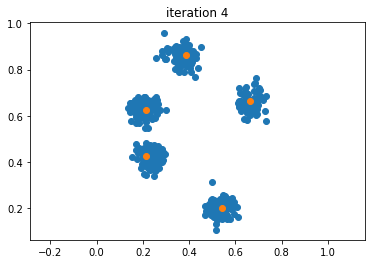

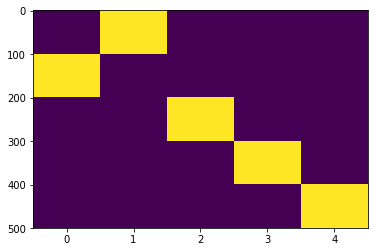

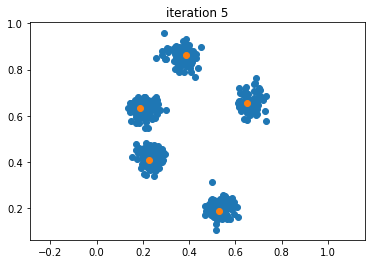

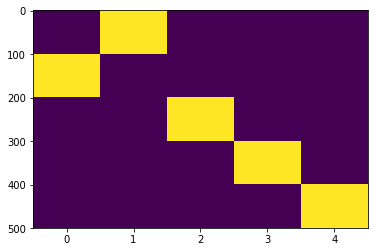

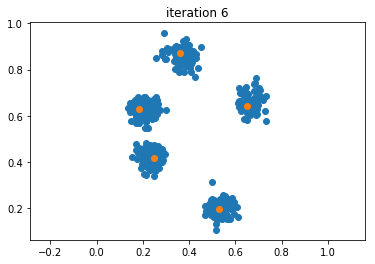

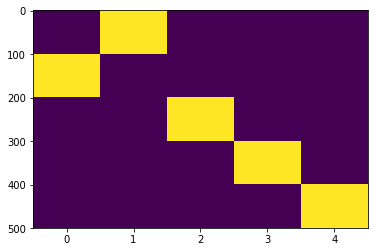

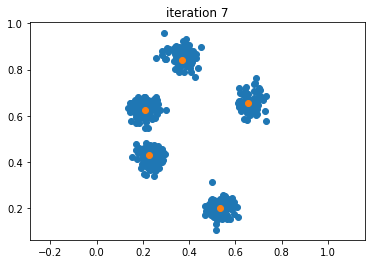

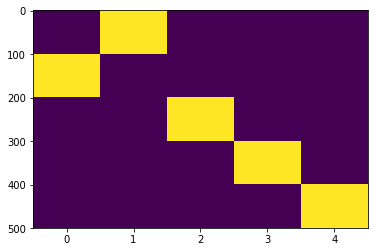

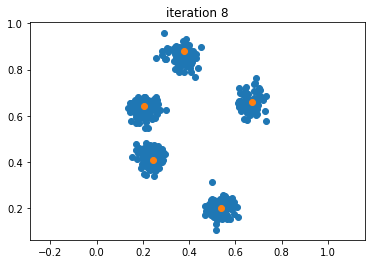

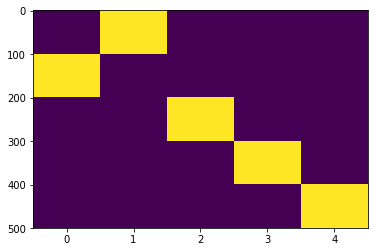

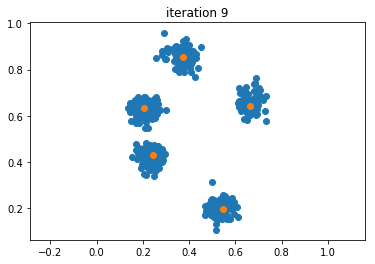

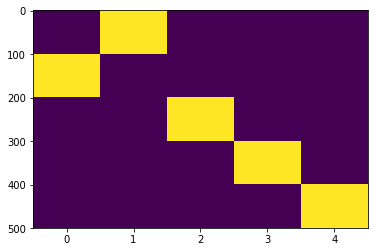

In [550]:
# Initialize
n_components = 5
# initialize to 5 first points
#centroids = X[:n_components].clone()
centroids = torch.zeros_like(X[:n_components])  # will get stuck
iterations = 10
regularization = 1000.
for iteration in xrange(iterations):
    plt.figure()
    plot_samples(X)
    plot_samples(centroids)
    plt.title('iteration {}'.format(iteration))
    
    # Expectation - Compute Sinkhorn distance
    distances = get_pairwise_distances(X, centroids)
    dst, P, u, v = compute_sinkhorn(distances, regularization=regularization)
    print '\nunstable dst', dst.item()
    dst, P, u, v = compute_sinkhorn_stable(distances, regularization=regularization)
    print 'stable dst', dst.item()

    soft_assignments = P / P.sum(0, keepdim=True)  # P_ij / sum_i P_ij is soft-assignment of cluster j

    # Minimization
    centroids = torch.matmul(soft_assignments.t(), X)
    
    centroids.add_(0.01 * torch.randn(centroids.size()))
    
    print centroids
    print P.sum(0)
    
    #print soft_assignments
    plt.figure()
    plt.imshow(P, aspect='auto')

Text(0.5,1,'K-Means Cost 0.00215')

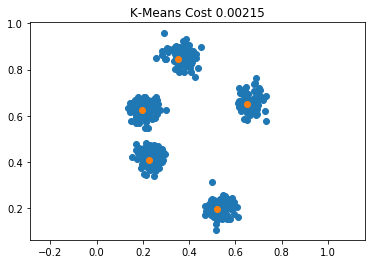

In [546]:
# Plot centroids
plt.figure()
plot_samples(X)
plot_samples(centroids)

# Plot loss
__, assignments = torch.min(distances, 1)
cost = ((X-centroids[assignments])**2).sum() / len(X)
plt.title('K-Means Cost {:.5f}'.format(cost))

In [523]:
centroids

tensor([[ 0.6611,  0.6575],
        [ 0.5342,  0.1981],
        [ 0.5351,  0.1988],
        [ 0.2190,  0.5241],
        [ 0.3669,  0.8550]])

In [528]:
soft_assignments

tensor([[ 5.4754e-11,  1.0095e-02,  9.9039e-03,  7.1279e-13,  6.4234e-22],
        [ 2.6031e-13,  9.9664e-03,  1.0032e-02,  3.9704e-13,  5.0166e-24],
        [ 3.4458e-13,  9.9776e-03,  1.0021e-02,  1.9038e-12,  2.4329e-23],
        ...,
        [ 1.7513e-08,  8.8204e-24,  6.4729e-24,  1.6598e-09,  9.9247e-03],
        [ 9.7817e-10,  1.1483e-24,  8.4455e-25,  5.1182e-09,  9.9247e-03],
        [ 3.7875e-10,  1.6427e-24,  1.2151e-24,  1.6615e-08,  9.9247e-03]])